# Problem statement [Auto Tag](https://www.hackerearth.com/challenges/competitive/hackerearth-deep-learning-challenge-auto-tag-images-gala/)

Galas are the biggest party of the year. Hosting firms of these events are well aware that everyone from around the world has their eyes on these nights—be it for inspiration or for critique. It takes months of meticulous planning and delegation to host these events impeccably.

One such firm has decided to take a data-driven approach for planning their gala nights. Aesthetics and entertainment are the most crucial segments of these events. So, this firm has hired you to help them aggregate and classify all images. These images are published by attendees and the paparazzi on various social media channels and other sources. You are required to build an image auto-tagging model to classify these images into separate categories.

# Dataset

The dataset consists of 5,983 images that belong to 4 categories. These categories are food, attire, decor and signage, and miscellaneous.

The benefits of practicing this problem by using Machine Learning or Deep Learning techniques are as follows:

This challenge encourages you to apply your Machine Learning skills to build models that classify images into multiple categories
This challenge helps you enhance your knowledge of classification actively. It is one of the basic building blocks of Machine Learning and Deep Learning techniques.
You are required to build a model that auto-tag images and classifies them into various categories of aesthetics and entertainment for a gala night.

## Google Drive mount and Imports

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
import itertools

from collections import defaultdict, Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.utils import to_categorical
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta, Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.callbacks.callbacks import EarlyStopping
from keras.regularizers import l2

from tqdm import tqdm

## 1. Load Data

In [0]:
data_dir = "/content/gdrive/My Drive/Dataset/HackerEarth/AutoTag/dataset/"

train_img_dir = "/content/gdrive/My Drive/Dataset/HackerEarth/AutoTag/dataset/Train Images/"
test_img_dir = "/content/gdrive/My Drive/Dataset/HackerEarth/AutoTag/dataset/Test Images/"

train_dir = data_dir + "/" + "train/"
validation_dir = data_dir + "/" + "validation/"
test_dir = "/content/gdrive/My Drive/Dataset/HackerEarth/AutoTag/dataset/test/"

train_df = pd.read_csv(data_dir + "/" + "train.csv")
test_df = pd.read_csv(data_dir + "/" + "test.csv")

In [0]:
def load_data(train_df, width, height, channels):
    data, labels = list(), list()
    datagen = ImageDataGenerator(
        rotation_range = 40, 
        shear_range = 0.2, 
        zoom_range = 0.2, 
        horizontal_flip = True, 
        brightness_range = (0.5, 1.5)
        )
    
    for i in tqdm(range(train_df.shape[0])):
        img = load_img('/content/gdrive/My Drive/Dataset/HackerEarth/AutoTag/dataset/Train Images/'+str(train_df['Image'][i]), target_size=(64, 64, 3), grayscale=False)
        img = img_to_array(img)
        img /= 255.0
        x = img
        data.append(img)
        labels.append(train_df['Class'][i])
        x = x.reshape((1, ) + x.shape)  
        
        # Generating and saving 5 augmented samples using the above defined parameters.  
        for index, batch in enumerate(datagen.flow(x, batch_size=1)):
            if index > 5:
                break
            bat = batch.reshape(64, 64, 3)
            bat /=255.0
            data.append(bat)
            labels.append(train_df['Class'][i])
    data = np.asarray(data)
    labels = np.asarray(labels)

    return data, labels

In [7]:
width, height, channels = 64, 64, 3

data, labels = load_data(train_df, width, height, channels)
le = LabelEncoder()
labels = le.fit_transform(labels)
cat_labels = to_categorical(labels)

100%|██████████| 5983/5983 [36:05<00:00,  2.76it/s]


In [9]:
x_train, x_validation, y_train, y_validation = train_test_split(data, cat_labels, test_size=0.33, stratify=labels)

print(F"Training data stats: {x_train.shape}, {y_train.shape}")
print(F"Validation data stats: {x_validation.shape}, {y_validation.shape}")

Training data stats: (28060, 64, 64, 3), (28060, 4)
Validation data stats: (13821, 64, 64, 3), (13821, 4)


## 2. Create NN models
    a. Cifar 10
    b. Transfer Learning using VGG-19

In [0]:
num_labels = 4
epochs = 50
batch_size = 32

num_features = 32

### Cifar-10

In [0]:
def cifar_10_arch():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(width, height, channels), activation="relu"))
    model.add(Conv2D(32, (3, 3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation="relu"))
    model.add(Conv2D(64, (3, 3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(num_labels, activation="softmax"))

    print(model.summary())

    opt = RMSprop(learning_rate=0.0001, decay=1e-6)
    
    # Let's train the model using RMSprop
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

    return model

In [15]:
cifar10_model = cifar_10_arch()

history = cifar10_model.fit(x_train, y_train, 
                            epochs=epochs, 
                            batch_size=batch_size, 
                            validation_data=(x_validation, y_validation))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 62, 62, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 31, 31, 64)        18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 64)       

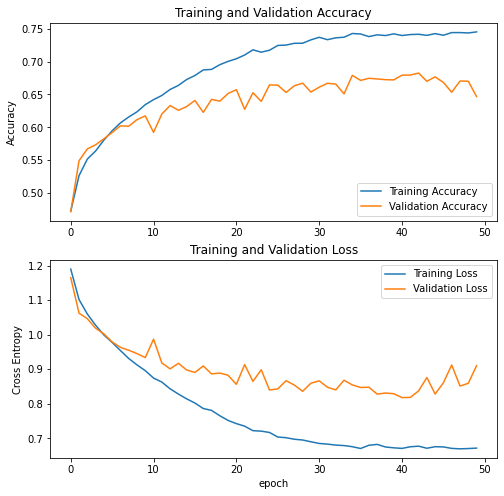

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [17]:
predictions = cifar10_model.predict(x_validation)
y_pred = np.argmax(predictions, axis=1)

cm = confusion_matrix(y_pred, np.argmax(y_validation, axis=1))
cr_report = classification_report(y_pred, np.argmax(y_validation, axis=1))

print(cr_report)

              precision    recall  f1-score   support

           0       0.88      0.54      0.67      6366
           1       0.63      0.74      0.68      1475
           2       0.66      0.74      0.70      4723
           3       0.32      0.75      0.45      1257

    accuracy                           0.65     13821
   macro avg       0.62      0.69      0.62     13821
weighted avg       0.73      0.65      0.66     13821



[[3428  282 1527 1129]
 [  63 1086  149  177]
 [ 353  212 3476  682]
 [  62  137  110  948]]


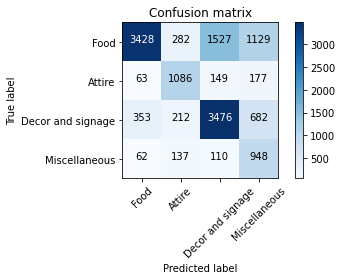

In [18]:
labels = ['Food', 'Attire', 'Decor and signage', 'Miscellaneous']
title='Confusion matrix'
print(cm)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

### FER 2013

In [0]:
def fer13_model_arch():
    model = Sequential()

    model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 3), data_format='channels_last', kernel_regularizer=l2(0.01)))
    model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Flatten())

    model.add(Dense(2*2*2*num_features, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(2*2*num_features, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(2*num_features, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_labels, activation='softmax'))

    print(model.summary())

    #Compliling the model with adam optimixer and categorical crossentropy loss
    model.compile(loss="categorical_crossentropy",
                  optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
                  metrics=['accuracy'])

    return model

In [29]:
fer13_model = fer13_model_arch()

history = fer13_model.fit(x_train, y_train, epochs=epochs, validation_data=(x_validation, y_validation))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 62, 62, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 62, 62, 32)        128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 31, 31, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 31, 31, 64)       

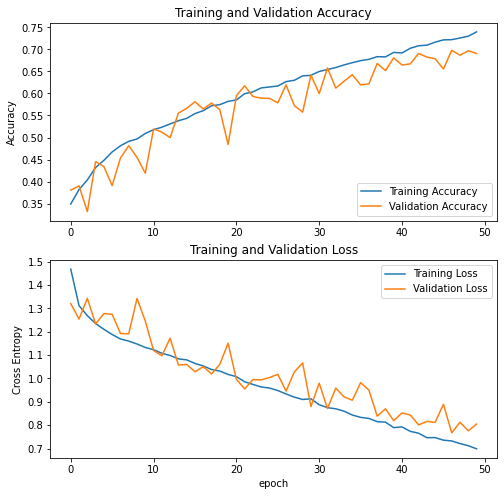

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [31]:
predictions = fer13_model.predict(x_validation)
y_pred = np.argmax(predictions, axis=1)

cm = confusion_matrix(y_pred, np.argmax(y_validation, axis=1))
cr_report = classification_report(y_pred, np.argmax(y_validation, axis=1))

print(cr_report)

              precision    recall  f1-score   support

           0       0.69      0.72      0.71      3784
           1       0.63      0.83      0.72      1307
           2       0.87      0.66      0.75      6924
           3       0.41      0.66      0.50      1806

    accuracy                           0.69     13821
   macro avg       0.65      0.72      0.67     13821
weighted avg       0.74      0.69      0.70     13821



[[2713   72  466  533]
 [  32 1084   65  126]
 [ 902  384 4555 1083]
 [ 259  177  176 1194]]


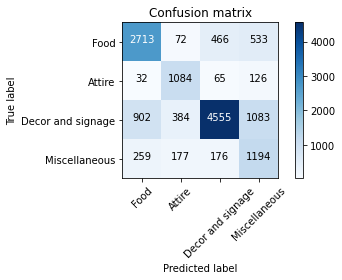

In [32]:
labels = ['Food', 'Attire', 'Decor and signage', 'Miscellaneous']
title='Confusion matrix'
print(cm)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

## 3. Final Output

In [33]:
test_data = list()

for i in tqdm(range(test_df.shape[0])):
    img = load_img('/content/gdrive/My Drive/Dataset/HackerEarth/AutoTag/dataset/Test Images/'+str(test_df['Image'][i]), 
                   target_size=(width, height, channels), 
                   grayscale=False
                   )
    img = img_to_array(img)
    img /= 255.0
    test_data.append(img)

test_data = np.asarray(test_data)
print(F"Test data stats : {test_data.shape}")

100%|██████████| 3219/3219 [00:04<00:00, 650.40it/s]


Test data stats : (3219, 64, 64, 3)


In [0]:
predictions = fer13_model.predict(test_data)
y_pred = np.argmax(predictions, axis=1)

pd.DataFrame({"submission.csv": y_pred}).to_csv("/content/gdrive/My Drive/Dataset/HackerEarth/AutoTag/submission.csv", index=False)